Epoch 1/100
1030/1030 [==============================] - 83s 79ms/step - loss: 1.3049 - accuracy: 0.5985 - val_loss: 0.7191 - val_accuracy: 0.8381
Epoch 2/100
1030/1030 [==============================] - 82s 80ms/step - loss: 0.5372 - accuracy: 0.8256 - val_loss: 0.4938 - val_accuracy: 0.8415
Epoch 3/100
1030/1030 [==============================] - 82s 79ms/step - loss: 0.3539 - accuracy: 0.8667 - val_loss: 0.4622 - val_accuracy: 0.8488
Epoch 4/100
1030/1030 [==============================] - 82s 80ms/step - loss: 0.2901 - accuracy: 0.8844 - val_loss: 0.4846 - val_accuracy: 0.8452
Epoch 5/100
1030/1030 [==============================] - 83s 81ms/step - loss: 0.2540 - accuracy: 0.8920 - val_loss: 0.4739 - val_accuracy: 0.8563
Epoch 6/100
1030/1030 [==============================] - 81s 78ms/step - loss: 0.2275 - accuracy: 0.9003 - val_loss: 0.5073 - val_accuracy: 0.8500
Epoch 7/100
1030/1030 [==============================] - 82s 80ms/step - loss: 0.2133 - accuracy: 0.9046 - val_loss: 0

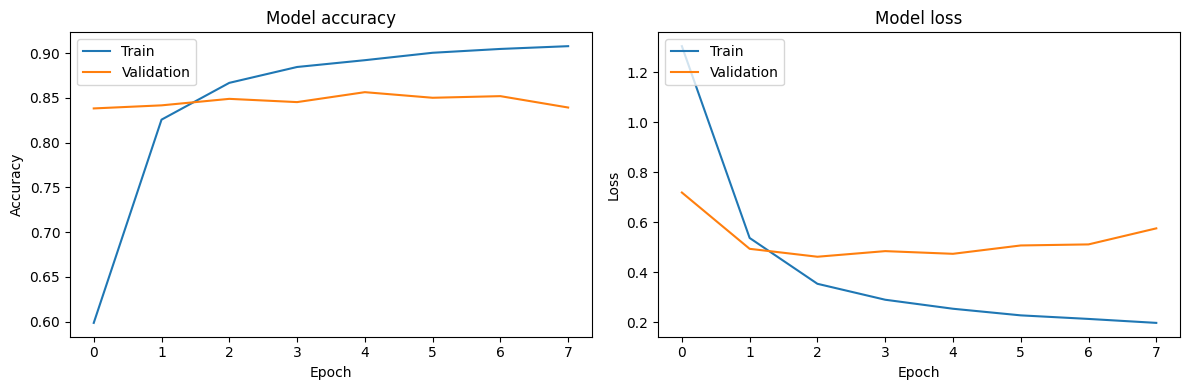

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Embedding, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import RandomOverSampler

# Load the dataset
df = pd.read_csv('/content/cleaned_dataset_combined (4).csv')

# Define feature and target variables
X = df['merged_tweet']
y = df['class']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use RandomOverSampler to oversample the minority class in the training set
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train.values.reshape(-1, 1), y_train)

# Convert the resampled data back to their original shape
X_train_resampled = X_train_resampled.flatten()

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_resampled)

X_train_seq = tokenizer.texts_to_sequences(X_train_resampled)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to ensure uniform length
max_sequence_length = max(len(seq) for seq in X_train_seq)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train_resampled)
y_test_one_hot = to_categorical(y_test)

# Build the CNN model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 128, input_length=max_sequence_length))
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(len(df['class'].unique()), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_padded, y_train_one_hot, epochs=100, batch_size=32, validation_data=(X_test_padded, y_test_one_hot), callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test_one_hot)
print(f'Test set accuracy: {accuracy:.2f}')

# Generate classification report
y_pred = model.predict(X_test_padded)
y_pred_classes = y_pred.argmax(axis=1)
y_test_classes = y_test_one_hot.argmax(axis=1)

print(classification_report(y_test_classes, y_pred_classes))

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()
